In [1]:
import numpy as np
import pandas as pd
import re
import time
import requests
from bs4 import BeautifulSoup
from datetime import datetime, date

from random import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# current version of seaborn generates a bunch of warnings that we'll ignore
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

In [2]:
# Use this to test for captcha block or IP ban
def get_URL(position,location):
    #from torrequest import TorRequest
    """[Build a template url for a dummy call to verify the site isn't returning a captcha]
    Args:
        position ([string]): [job for query]
        location ([string]): [location for query]
    Returns:
        [string]: [formatted url]
    """
    template = 'https://www.indeed.com/jobs?q={}&l={}&fromage=3&sort=date'
                
    position = position.replace(' ', '%20')
    location = location.replace(' ', '+')
    url = template.format(position,location)
    return url

# The below is just to check that the response is '200', successful connection
position = 'data scientist'
location = 'california'
response = requests.get(get_URL(position,location))
# This will either return an HTML block for a captcha or of a search result
soup = BeautifulSoup(response.text, 'html.parser')
response

<Response [200]>

In [3]:
def get_desc_features(job_url):
    """Parses each job description, searching for and extracting values for features

    Args:
        job_url (string): http address of each job posting

    Returns:
        tuple: job feature values
    """
    response_job_desc = requests.get(job_url)
    soup = BeautifulSoup(response_job_desc.text, 'html.parser')

    
    try:
        salary_and_job_type = soup.find('div', id='salaryInfoAndJobType').text.strip()
    except:
        salary_and_job_type = None
    if salary_and_job_type == None:
        try:
            salary_and_job_type = soup.find('div',id="icl-u-xs-block jobsearch-ReqAndQualSection-item--title").text.replace("\n", "").strip()
        except:
            salary_and_job_type = None
    #TODO get benefits from its designated section
    
    
    try:
        salary_guidance = []
        items = soup.find('ul',class_='css-1lyr5hv eu4oa1w0')
        for i in items:
            salary_guidance.append(i.text)
    except:
        salary_guidance = None
        
        
    try:
        job_type_items = []
        job_type_from_section = soup.find('div',class_='jobsearch-JobDescriptionSection-sectionItem').next_sibling.children
        for i in job_type_from_section:
            if i.text == 'Job Type':
                continue
            else:
                job_type_items.append(i.text)
    except:
        job_type_items = None
        
    
    try:
        requirements = soup.find(class_="icl-u-xs-block jobsearch-ReqAndQualSection-item--title").text.replace("\n", "").strip()      

    except:
        requirements = None
        
        
    try:
        description = soup.find(id="jobDescriptionText").text.replace('\n', '')
    except:
        description = None
        
        
    # A nifty little workaround for evading detection.
    time.sleep(.3+random()*3)
    #TODO assess h2 tags commonalities to determine if these section descriptions are from Indeed or are at least of only a few variations.
        #you could then distinguish the description into sections and conduct NLP etc each.
    raw_desc_soup = soup
    return salary_and_job_type, salary_guidance, job_type_items, requirements, description, raw_desc_soup

In [4]:
#TODO condense these with lists, particularly fields that have .text.strip()
def get_features(post):
    """parses search results and extracts basic job feature values,
        then combines this with output of 'get_desc_features' function.

    Args:
        post (string): response for each post in search results page

    Returns:
        dict: single-feature deep dictionary of features (dictionary keys) and their values (dictionary values)
    """


    #check if new url is in list
    url = 'https://www.indeed.com'+ post.find('a', href = re.compile(r'[/]([a-z]|[A-Z])\w+')).attrs['href']
    title = post.find('h2',
    attrs={'class': lambda e: e.startswith('jobTitle') if e else False}).text.replace('new', '')


    company = post.find('span', 'companyName').text.strip()
    try:
        rating = post.find('span', 'ratingNumber').text
    except:
        rating = None

    location = post.find('div', 'companyLocation').text.strip()
    postDate = post.find('span', 'date').text
    extractDate = datetime.today().strftime('%Y-%m-%d')
    summary = post.find('div', 'job-snippet').text.strip().replace('\n', ' ')





            
    salary, estimated_salary, job_type_items, requirements, description, raw_desc_soup = get_desc_features(url)

    datapoint_dict = {}
    datapoint_dict = {
                            'title':title,
                            'company':company,
                            'rating':rating,
                            'location':location,
                            'estimated_salary':estimated_salary,
                            'postDate':postDate,
                            'extractDate':extractDate,
                            'summary':summary,
                            'url':url,
                            'salary':salary,
                            'job_type_items':job_type_items,
                            'requirements':requirements,
                            'description':description,
                            'raw_desc_soup':raw_desc_soup}
    





    return datapoint_dict

In [5]:
def main(position, location):
    """[Conducts the web scraping process]
    Args:
        position ([string]): [job position for indeed.com query]
        position ([string]): [job location for indeed.com query]
        
        Returns:
        [csv]: [scraped data]
    """
    start = time.time()

    data = pd.DataFrame()
    urls = pd.read_csv(f'../app/data/total.csv', usecols = ['url'])
    urls.drop_duplicates(inplace=True)


    
    print(f'Scraping for {position} in {location}')
    # extract the job data
    while True:
        response = requests.get(get_URL(position, location))
        soup = BeautifulSoup(response.text, 'html.parser')
        searchResults = soup.find('div', id='mosaic-provider-jobcards')
        refinedsearchResults = searchResults.find_all('div', attrs={'class': lambda e: e.startswith('cardOutline') if e else False})
        
        n = 0
        for post in refinedsearchResults:
            url = 'https://www.indeed.com'+ post.find('a', href = re.compile(r'[/]([a-z]|[A-Z])\w+')).attrs['href']
            if url not in urls.url.values:
                datapoint = get_features(post)
                data = data.append(datapoint, ignore_index=True)
            else:
                n+=1
            print(f'Scraping for {position} in {location}')
            print(f' skipped {n}')
            clear_output(wait=True)

        
        try:
            url = 'https://www.indeed.com' + soup.find('a', {'aria-label': 'Next'}).get('href')
        except AttributeError:
            break

    


    name = position.replace(' ','_')
    loc = location.replace(' ','_')


    # save the job data
    data.to_csv(f'../app/data/scraped_{name}_{loc}.csv', index=False)
    print(f'Scraped {len(data)} new records for {location}')
    clear_output(wait=True)

    end = time.time()
    total_time = end - start
    return round(total_time, 4), len(data)

In [6]:
state_names = ['remote', 'alabama', 'arkansas',  'arizona', 'california', 'colorado', 'connecticut', 'delaware', 'florida', 'georgia', 'iowa', 'idaho', 'illinois', 'indiana', 'kansas', 'kentucky', 'louisiana', 'maryland', 'massachusetts', 'maine', 'michigan', 'minnesota', 'missouri', 'mississippi', 'montana', 'north carolina', 'north dakota', 'nebraska', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'nevada',  'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina', 'south dakota', 'tennessee', 'texas', 'utah', 'virginia',  'vermont', 'washington', 'wisconsin', 'west virginia', 'wyoming']


times = pd.DataFrame()
for state in state_names:
    position = 'data scientist' 
    location = state
    elapsed, size = main(position,location )

    scrape_metrics = {
                    'location':location,
                    'elapsed':round(elapsed, 2),
                    'size':size+1,
                    'average_time' :round(elapsed/size, 2)}
    
    times = times.append(scrape_metrics, ignore_index=True)

Scraping for data scientist in wyoming
Scraped 5 new records for wyoming


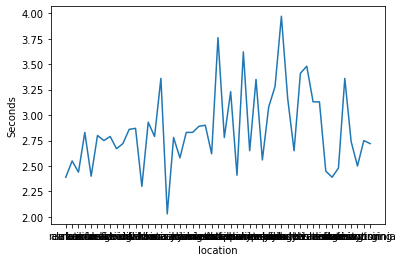

In [7]:
# In preparation for AWS deploymnet I'm progressively adding to the analysis of the webscrapping stage.
ax = sns.lineplot(data = times, x= times.location, y = times.average_time)
ax.set_ylabel('Seconds')

plt.show()

The  below is used for various adjustments to my webscraping process.

### Concatenating Data With New

In [14]:
state_names = ['alabama', 'arkansas', 'arizona', 'california', 'colorado', 'connecticut', 'delaware', 'florida', 'georgia', 'remote', 'iowa', 'idaho', 'illinois', 'indiana', 'kansas', 'kentucky', 'louisiana', 'massachusetts', 'maryland', 'maine', 'michigan', 'minnesota', 'missouri', 'mississippi', 'montana', 'north carolina', 'north dakota', 'nebraska', 'new hampshire', 'new jersey', 'new mexico', 'nevada', 'new york', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina', 'south dakota', 'tennessee', 'texas', 'utah', 'virginia',  'vermont', 'washington', 'wisconsin', 'west virginia', 'wyoming']

lst = []
records = 0
cols = ['rating', 'company', 'title', 'location', 'extractDate', 'postDate', 'requirements', 'description', 'summary', 'salary', 'estimated_salary', 'url']
for i in state_names:
    i = i.replace(' ','_')
    try:
        location = pd.read_csv(f'../app/data/scraped_data_scientist_{i}.csv', usecols=cols)
        records += len(location)
        lst.append(location)
        print(f'Scraped  {len(location)} new records for {i}')
    except:
        continue

print(f'Scraped Records: {(records)}')


## unblock if you miss too many days
#todays_scrape = pd.concat(lst)
#todays_scrape.to_csv('../app/data/total.csv', index= False)


total = pd.read_csv(f'../app/data/total.csv')
lst.append(total)
total = pd.concat(lst)
total = total[total['description'].notnull()]
""" another method perhaps
len(data)
data.dropna(subset=['description'], inplace=True)
len(data)
"""

#total.drop_duplicates(subset=['title','company','location','url'], inplace=True)
total.to_csv('../app/data/total.csv', index= False)
print(f'Total Records: {(len(total))}')
total



Scraped  8 new records for alabama
Scraped  6 new records for arkansas
Scraped  394 new records for arizona
Scraped  135 new records for california
Scraped  172 new records for colorado
Scraped  164 new records for connecticut
Scraped  7 new records for delaware
Scraped  220 new records for florida
Scraped  1286 new records for georgia
Scraped  375 new records for remote
Scraped  6 new records for iowa
Scraped  9 new records for idaho
Scraped  26 new records for illinois
Scraped  14 new records for indiana
Scraped  7 new records for kansas
Scraped  6 new records for kentucky
Scraped  2 new records for louisiana
Scraped  87 new records for massachusetts
Scraped  166 new records for maryland
Scraped  6 new records for maine
Scraped  62 new records for michigan
Scraped  66 new records for minnesota
Scraped  24 new records for missouri
Scraped  5 new records for mississippi
Scraped  7 new records for montana
Scraped  156 new records for north_carolina
Scraped  7 new records for north_dakot

,company,description,estimated_salary,extractDate,location,postDate,rating,requirements,salary,summary,title,url
0,Logic20/20 Inc.,Company Description We’re a six-time “Best C...,NaN,2022-07-21,"Huntsville, AL",PostedToday,3.6,NaN,"From $85,000 a year - Full-time","Along the way, you’ll collaborate daily with a...",Data Scientist,https://www.indeed.com/rc/clk?jk=d2116518a000d...
1,Logic20/20 Inc.,Company Description We’re a six-time “Best C...,NaN,2022-07-21,"Huntsville, AL",PostedToday,3.6,NaN,"From $125,000 a year - Full-time",Experience building data and computational sys...,Big Data Engineer - PySpark,https://www.indeed.com/rc/clk?jk=8be47a6ce1d4b...
6,PNC Financial Services Group,"Position Overview At PNC, our people are our ...",NaN,2022-07-21,"Remote in Montgomery, AL",PostedPosted 1 day ago,3.5,NaN,NaN,Experience in data mining/exploration in banki...,Data Scientist Sr,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
7,AL2S3 LTD,Job Description An award-winning lobal early ...,"['', 'Not provided by employer', ""$114K - $145...",2022-07-21,United States,PostedPosted 2 days ago,NaN,NaN,NaN,"Manipulate, summarise and analyse clinical tri...",Senior Statistician,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
0,Inconen,Statistician / Engineer SpecialistLocation: Ca...,NaN,2022-07-21,"Camden, AR 71701",PostedToday,4.6,Bachelor's (Preferred)US work authorization (P...,"$145,000 - $148,000 a year - Full-time",Work with cross-functional teams and subject-m...,Statistician / Engineer Specialist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
...,...,...,...,...,...,...,...,...,...,...,...,...
11018,Deloitte,HX TrustID Data Engineer Are you a talented so...,NaN,2022-07-19,"Milwaukee, WI 53202 (Juneau Town area)",PostedPosted 3 days ago,4.0,NaN,Full-time,Collaborate with project data scientists and c...,HX TrustID Data Engineer,https://www.indeed.com/rc/clk?jk=a95779526f822...
11019,Cytel - USA,Join us in playing an important part in helpin...,"['', 'Not provided by employer', ""$126K - $159...",2022-07-19,United States,PostedPosted 1 day ago,NaN,NaN,NaN,"For over thirty years, Cytel’s scientific rigo...",Principal Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
11020,"Cytel, Inc (USA)","At Cytel, we work hard to create successful ca...","['', 'Not provided by employer', ""$105K - $133...",2022-07-19,United States,PostedPosted 3 days ago,4.0,NaN,NaN,"Performing data manipulation, analysis and rep...",Senior Statistical Programmer,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
11021,Cytel - USA,Join us in playing an important part in helpin...,"['', 'Not provided by employer', ""$126K - $159...",2022-07-19,United States,PostedPosted 1 day ago,NaN,NaN,NaN,"For over thirty years, Cytel’s scientific rigo...",Principal Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


The below are bits of code I employ if something goes wrong with the webscraping process.

In [ ]:
"""#fix old imports

data['extractDate']= pd.to_datetime(data['extractDate'])

def pDate(row):
    from datetime import datetime, date, timedelta

    #days_ago = row['dateposted']
    delta = timedelta(0)
    try:
        return row['extractDate'] - delta
    except:
        return row

data['extractDate'] = data.apply( lambda row : pDate(row), axis = 1)
data['extractDate'] = data['extractDate'].astype(str)
#data.to_csv('../app/data/scraped_data_scientist_remote_2022-04-14.csv', index= False)
data.extractDate.unique()"""

In [ ]:
"""# codescraps in case they change the html and break my parsers

searchResults = soup.find('div', id='mosaic-provider-jobcards')
refinedsearchResults = searchResults.find_all('div', attrs={'class': lambda e: e.startswith('cardOutline') if e else False})
len(refinedsearchResults)
z = searchResults.children
lst = []
for i in z:
    lst.append(i)

x = lst[0]

#checking again
soup = BeautifulSoup(response.text, 'html.parser')
#searchResults = soup.find('div', id='mosaic-provider-jobcards')
refinedsearchResults = soup.find_all('div', attrs={'class': lambda e: e.startswith('cardOutline') if e else False})
        

raw_posts = []
for post in refinedsearchResults:
        raw_posts.append(post)
        n = 0

z = raw_posts[0]
url = z.find('a', href=True)
url


z.find('a', href = re.compile(r'[/]([a-z]|[A-Z])\w+')).attrs['href']
z

postDate = z.find('span', 'date').text
extractDate = datetime.today().strftime('%Y-%m-%d')
summary = z.find('div', 'job-snippet').text.strip().replace('\n', ' ')

summary

company_name = z.find('a', attrs={'class':'turnstileLink companyOverviewLink'}).text.strip()
company_name

job_title = z.find('a', attrs={'class':'jcs-JobTitle'}).text.strip()
job_title

"""